<h1> A Fraud Detection Case Study </h1>

<h2> Introduction </h2>
<p> In this case study, we will be working with a dataset containing transactions made by credit cards. The dataset contains transactions that occurred over a period of two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. </p>

<h2> Exploratory Analysis </h2>
<p> Let's start by importing the necessary libraries and loading the dataset. </p>

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [28]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [29]:
print(df.shape, df.columns, df.describe(), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

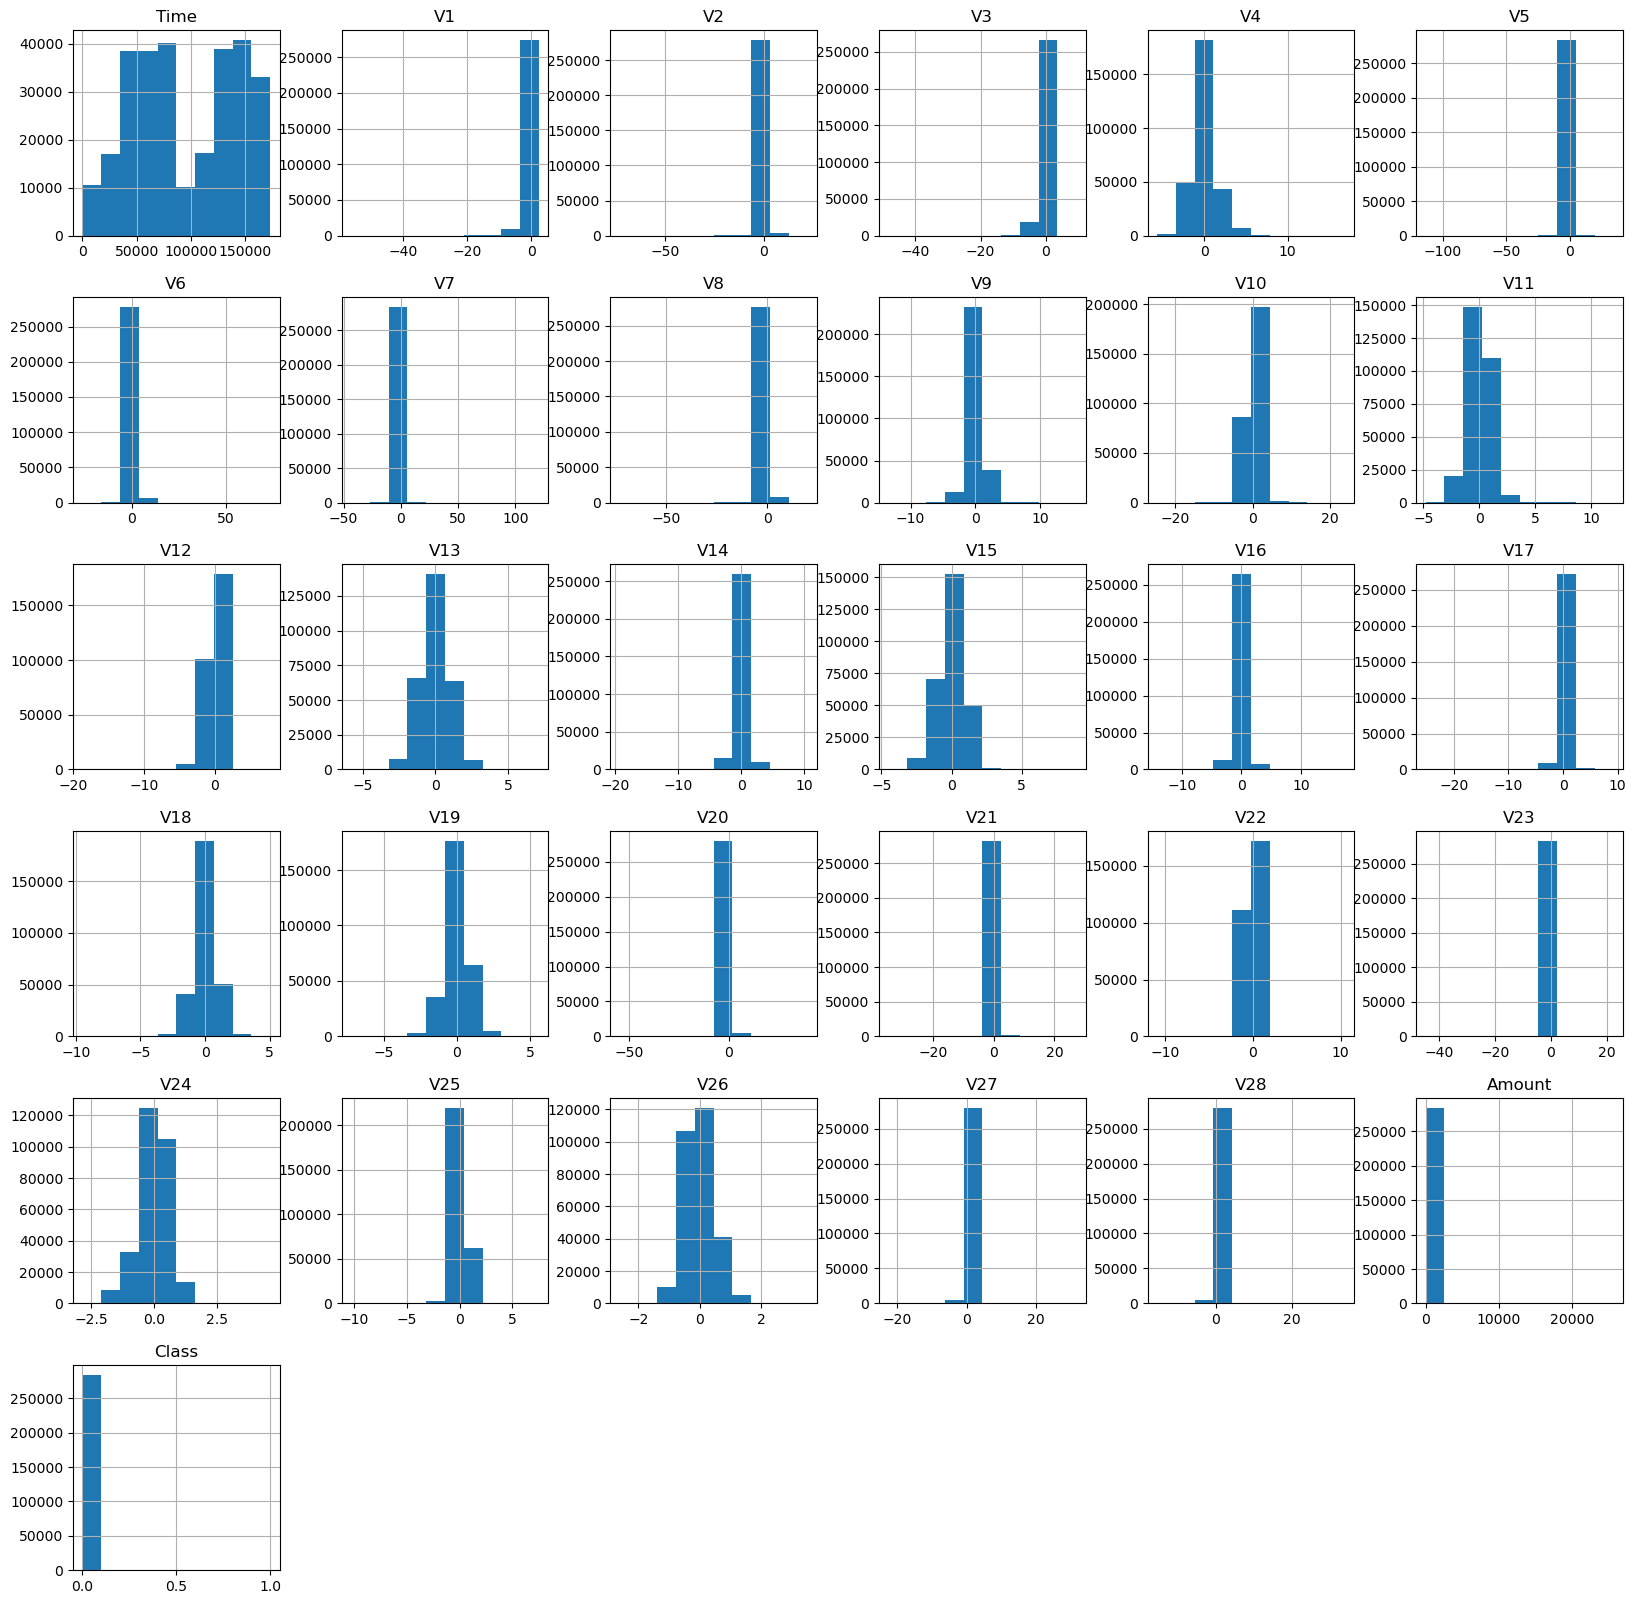

In [30]:
# check for outliers and skewness in the data
df.hist(figsize=(20,20))
plt.show()

In [31]:
#check for missing values
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

<h3> conclusion </h3>
<p> the data is clean and ready to be used for the model. </p>

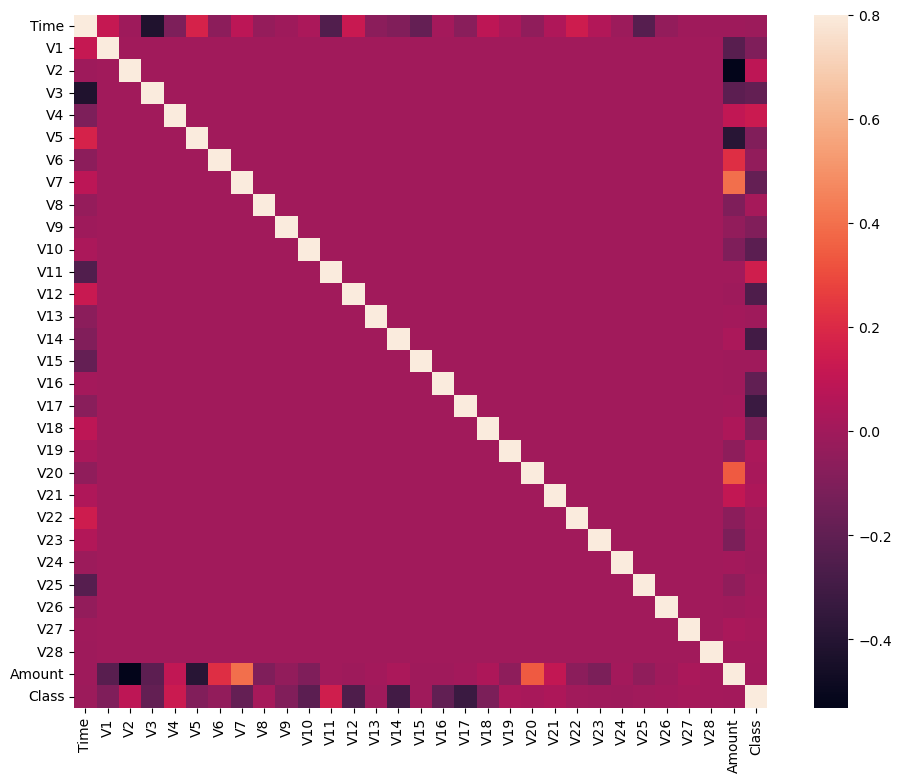

In [32]:
# correlation matrix
corrmat = df.corr()
fig = plt.figure(figsize = (12, 9))
sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

<h4> conclusion </h4>
<p> there is no correlation between the features and the target. </p>

<h2> Try the model </h2>
<p> Now that we have a dataset, let's try to train a model to predict the target. </p>

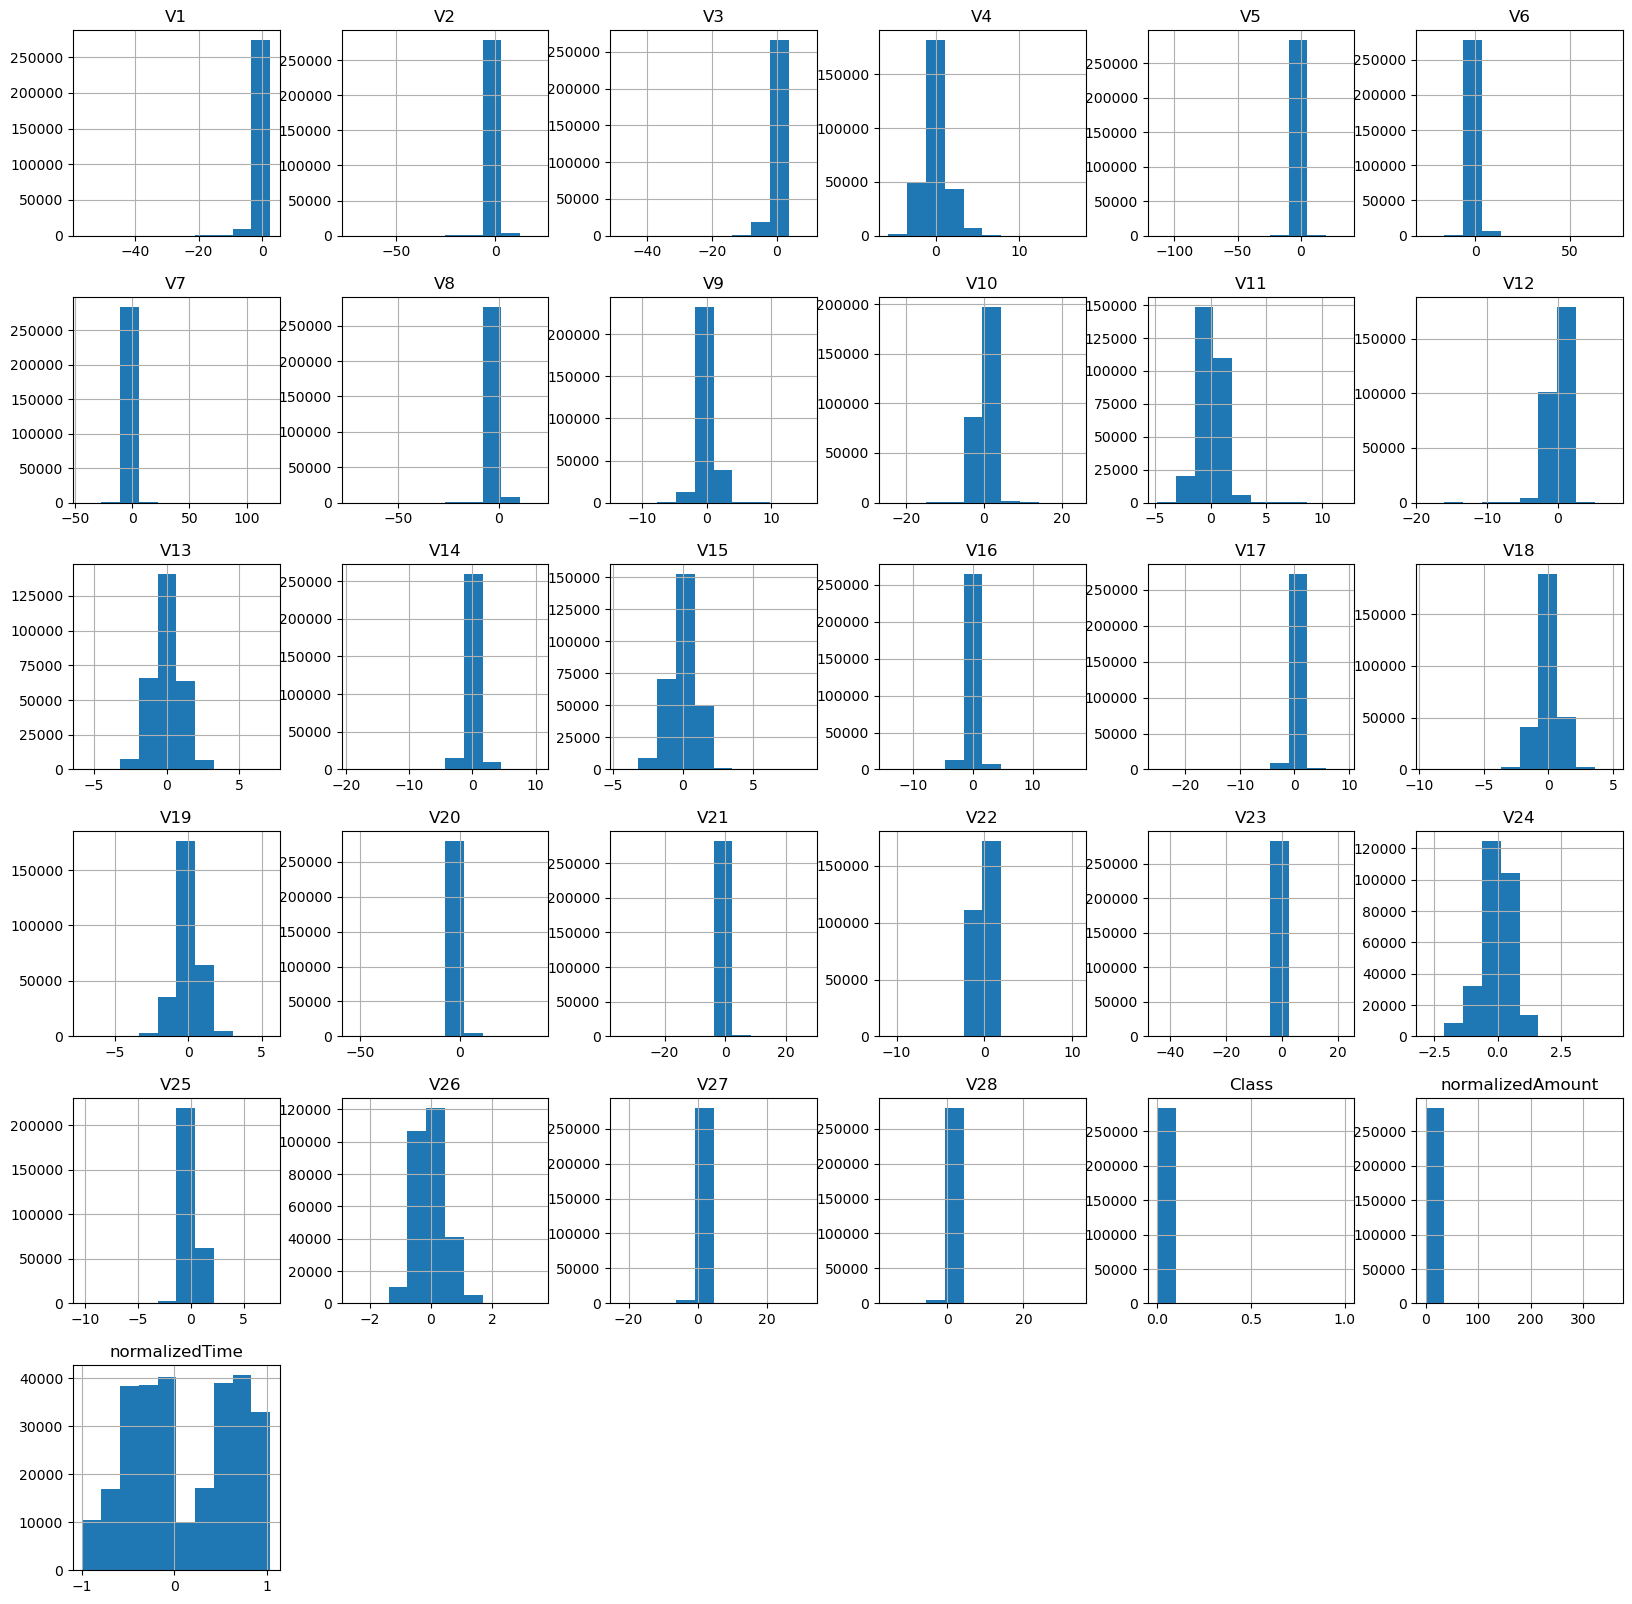

In [33]:
# scale all the features except the target variable
from sklearn.preprocessing import RobustScaler
df['normalizedAmount'] = RobustScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['normalizedTime'] = RobustScaler().fit_transform(df['Time'].values.reshape(-1,1))
df = df.drop(['Amount'], axis = 1)
df = df.drop(['Time'], axis = 1)
df.hist(figsize=(20,20))
plt.show()

In [34]:
#split the data into train and test
X = df.drop(['Class'], axis = 1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 101)

In [35]:

#make a pipeline for the models logistic regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

pipe = Pipeline([('classifier' , LogisticRegression())])

param_grid = [
    {'classifier' : [LogisticRegression()],
    'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
]

parm = GridSearchCV(param_grid=param_grid, estimator = pipe, cv = 5, verbose=2, n_jobs=-1)
best_model = parm.fit(X_train, y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test, y_test))
print("The best parameters for the model are:",best_model.best_params_)
print("The best estimator for the model is:",best_model.best_estimator_)
print("The best score for the model is:",best_model.best_score_)
print("The best index for the model is:",best_model.best_index_)
print("The best parameters for the model are:",best_model.cv_results_)
# print the confusion matrix
y_pred = best_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END classifier=LogisticRegression(), classifier__C=0.0001, classifier__penalty=l1, classifier__solver=liblinear; total time=   2.3s
[CV] END classifier=LogisticRegression(), classifier__C=0.0001, classifier__penalty=l1, classifier__solver=liblinear; total time=   2.3s
[CV] END classifier=LogisticRegression(), classifier__C=0.0001, classifier__penalty=l1, classifier__solver=liblinear; total time=   2.4s
[CV] END classifier=LogisticRegression(), classifier__C=0.0001, classifier__penalty=l1, classifier__solver=liblinear; total time=   2.4s
[CV] END classifier=LogisticRegression(), classifier__C=0.00026366508987303583, classifier__penalty=l1, classifier__solver=liblinear; total time=   2.4s
[CV] END classifier=LogisticRegression(), classifier__C=0.0001, classifier__penalty=l1, classifier__solver=liblinear; total time=   2.4s
[CV] END classifier=LogisticRegression(), classifier__C=0.00026366508987303583, classifier__penalty=

In [38]:
# print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.90      0.58      0.71       144

    accuracy                           1.00     85443
   macro avg       0.95      0.79      0.85     85443
weighted avg       1.00      1.00      1.00     85443



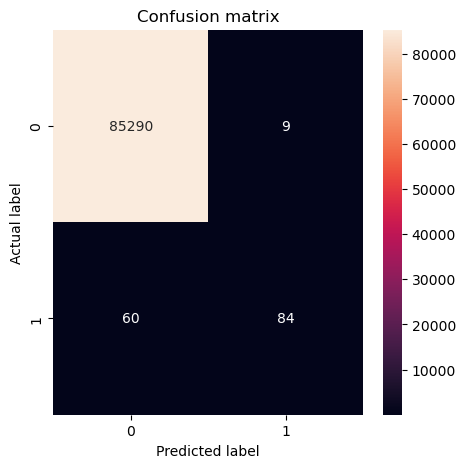

In [39]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_mat, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.show()

<h4> conclusion </h4>
<p> the model made it so well to predect the legit transactions but it failed to predict the fraud transactions. </p>

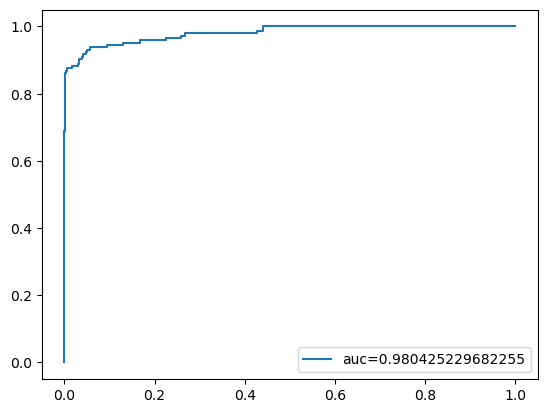

In [40]:
# print the ROC curve
y_pred_proba = best_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

<h2> Deal with the unbalanced data </h2>
<p> we will try to deal with the unbalanced data by using the SMOTE technique. </p>

In [43]:
# import smote to handle the imbalanced data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=101)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())



ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (/Users/amraly/anaconda3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py)